In [1]:
#imports 
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna 
import lightgbm as lgb
import xgboost as xgb

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

### Importing data and getting a peak into it

In [2]:
train = pd.read_csv('../input/tabular-playground-series-jan-2021/train.csv')
test  = pd.read_csv('../input/tabular-playground-series-jan-2021/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-jan-2021/sample_submission.csv')

#separating training data, all the columns and target columns 
features = [f'cont{x}'for x in range(1,15)]

data = train[features]
X_test = test[features]
target = train['target']
train.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


## Part 1 - Some EDA 

We will be looking at the features distribution, its correlation and Train, Test data distribution correspondance(if it doesn't match the exact distribution we can try altering it) and finally The target data distribution. 

### Starting with Training Data Visualization

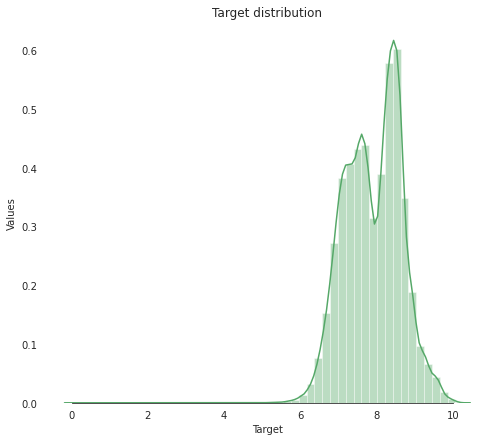

In [3]:
# some part of this code is adapted from this great notebook by Lavanya for beginners
#https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
#we will be analyzing the target value first

#setting up the platform
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.distplot(target, color="g")
ax.xaxis.grid(False)
ax.set(ylabel="Values")
ax.set(xlabel="Target")
ax.set(title="Target distribution")
sns.despine(trim=True, left=True)
plt.show()

We notice two things here:

1) The distribution is skewed as the left part is streached and              
2) It is made of multiple normal distribution (atleast two) as we can see the distribution splits around 8.

<Figure size 432x288 with 0 Axes>

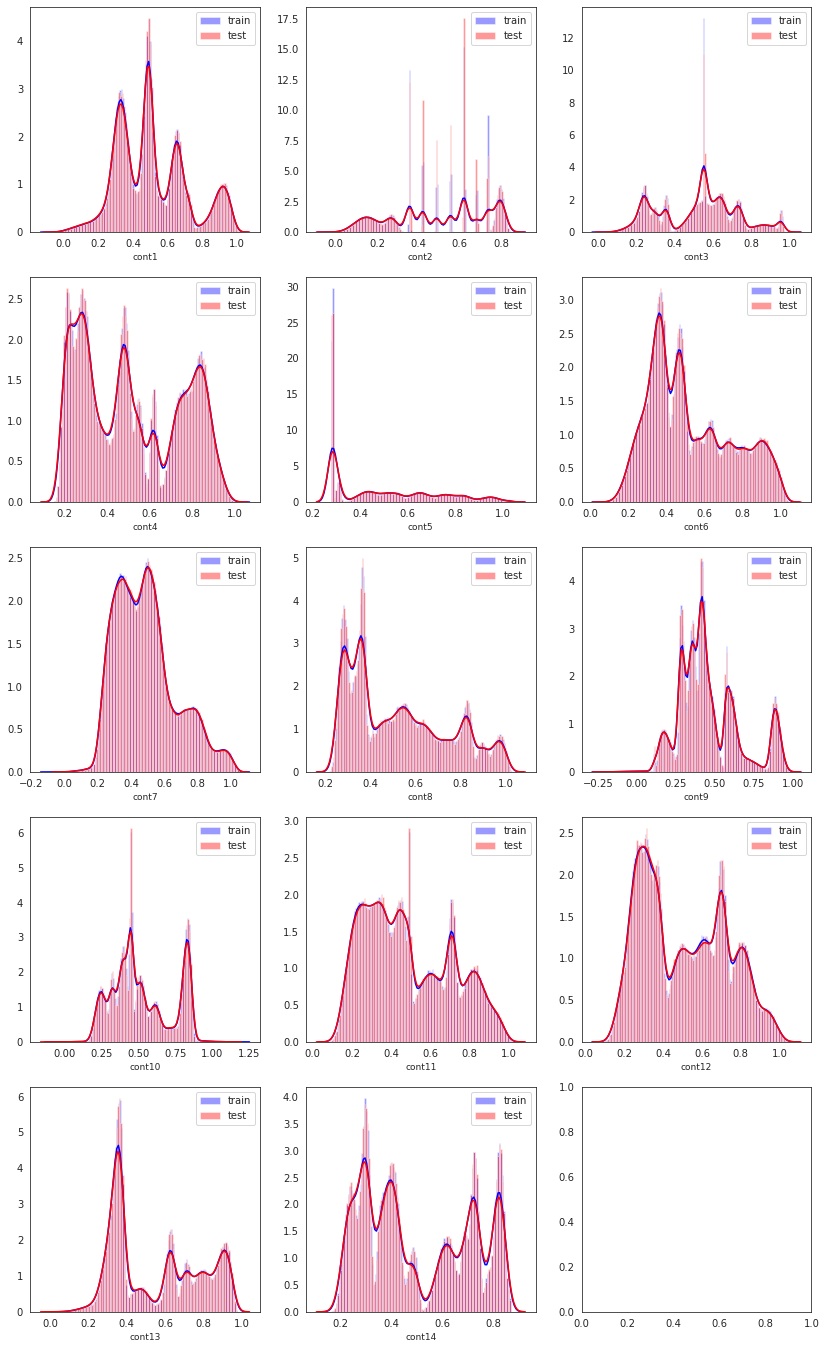

In [4]:
# we will look into the features distribution now, to get insight into the data
i = 1
plt.figure()
fig, ax = plt.subplots(5, 3,figsize=(14, 24))
for feature in features:
    plt.subplot(5, 3,i)
    sns.distplot(train[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test[feature],color="red", kde=True,bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

We can see that test and train data are almost identical, means the data distribution is looking same in the graph.

Also features, cont6, cont12, cont11 and cont13 looks similar in some fashion, Let's look at what the correlation data tells us about that.

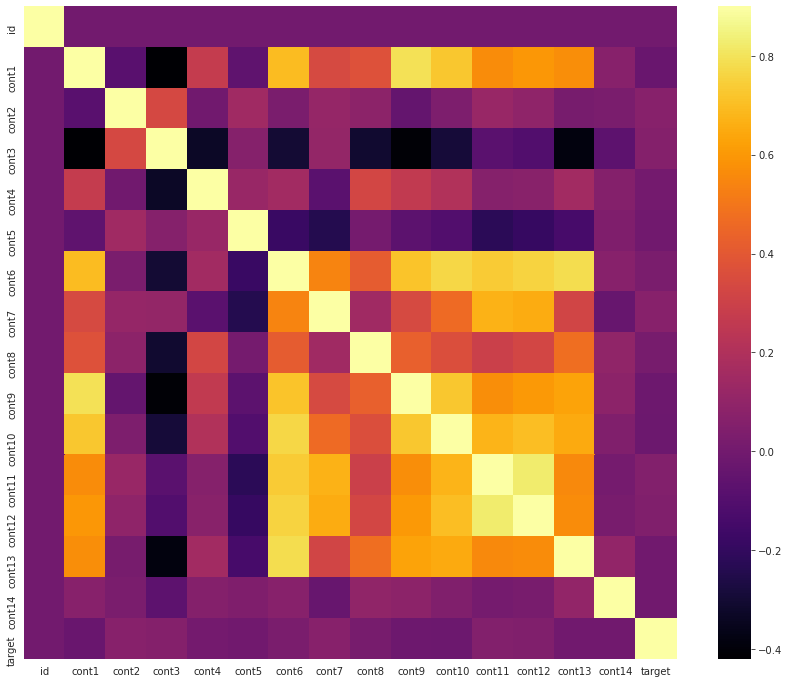

In [5]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="inferno", square=True)

Somehow the features cont6 to cont13 seem to be correlated!!

(I have tried only training XGBoost on them, but other features are also seem to play an important role in predicting the target, so the they are not the only ones impacting the regression results)

In [6]:
#normalising the training data
train_data = (data-data.mean())/data.std()
test_data = (X_test - X_test.mean())/X_test.std()

## Part 2 - training XGBoostRegressor (tuned using Optuna)

XGBoost works pretty well with regression tasks of these types.
Here, we are training the XGBoost model which is tuned using optuna. You can find how to optimize the hyperparameters [here](https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna) Great work by hamza. 
I have found these sets of hyper parameters works pretty well and performs better than normal parameters, I have found it by running it with multiple sets, so You may be interested in tuning those with GPUs enabled and multiple tries)

In [7]:
# code and parameters adapted from this great notebook by Hamza, 
#https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna

Best_trial = {'lambda': 0.0030282073258141168, 'alpha': 0.01563845128469084, 'colsample_bytree': 0.5,
             'subsample': 0.7,'n_estimators': 4000, 'learning_rate': 0.01,'max_depth': 15,
             'random_state': 2020, 'min_child_weight': 257,'tree_method':'gpu_hist'
             ,'predictor': 'gpu_predictor'}

#you might want to turn on the GPU from the Accelerator or just remove 'tree_method':'gpu_hist'
#from the parameters list
train = train_data
test = test_data
#train on 7 folds cross validation
preds = np.zeros(test.shape[0])
#creating 7 folds
kf = KFold(n_splits=7,random_state=48,shuffle=True)
rmse=[]
n=0
for trn_idx, test_idx in kf.split(train[features],target):
    #separating training and validation data from training columns
    X_tr,X_val=train[features].iloc[trn_idx],train[features].iloc[test_idx]
    #separating training and validation data from target values
    y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]
    
    #xgboost regressor with optimized parameters 
    model = xgb.XGBRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    #predicting on test data provided in separate file(actual test data not validation)
    preds+=model.predict(test[features])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1
print(f"mean RMSE for all the folds is {np.mean(rmse)}")

1 0.6982482820486355
2 0.6948960127774959
3 0.6966784180232913
4 0.6949063022234346
5 0.6957574725370432
6 0.6936439971610456
7 0.6959489813197524
mean RMSE for all the folds is 0.695725638012957


In [8]:
#ensemble with notebook submission found at great kernal
#https://www.kaggle.com/somayyehgholami/results-driven-tabular-playground-series-20
sub1 = pd.read_csv('../input/results-driven-tabular-playground-series-201/submission.csv')
predictions1 = sub1['target'].tolist()       #will give about 0.69673 with 75,25 ratio 

results = [x*0.66 + y*0.34 for x, y in zip(predictions1, preds)]
# sub['target']=results
# sub.to_csv('submission.csv', index=False)

## Part 3 LightGBM Model

Here we are building LightGBM model which is very power tool when tuned. We have tuned it using optuna(in another notebook), but make sure you run this on gpu as it will take a lot time in CPU iterations. The hyper-parameters are adapted from [this kernal](https://www.kaggle.com/hamditarek/tabular-playground-series-xgboost-lightgbm) but works with Normalized dataset pretty well. We are having normalized dataset which works slightly better than normal dataset (for XGBoost marginal difference) so we will stick to that for the next model.

In [9]:
# parameters from this awesome kernal 
# https://www.kaggle.com/hamditarek/tabular-playground-series-xgboost-lightgbm
Best_trial ={'random_state': 33,'n_estimators':5000,
 'min_data_per_group': 5,
 'boosting_type': 'gbdt',
 'device_type' : 'gpu',
 'num_leaves': 256,
 'num_iterations' : 5000,
 'max_dept': -1,
 'learning_rate': 0.005,
 'subsample_for_bin': 200000,
 'lambda_l1': 1.074622455507616e-05,
 'lambda_l2': 2.0521330798729704e-06,
 'n_jobs': -1,
 'cat_smooth': 1.0,
 'silent': True,
 'importance_type': 'split',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'bagging_fraction': 0.8206341150202605,
 'min_data_in_leaf': 100,
 'min_sum_hessian_in_leaf': 0.001,
 'bagging_freq': 6,
 'feature_fraction': 0.5,
 'min_gain_to_split': 0.0,
 'min_child_samples': 20}

In [10]:
preds = np.zeros(test.shape[0])
#creating 10 folds
kf = KFold(n_splits=10,random_state=48,shuffle=True)
rmse=[]
n=0
for trn_idx, test_idx in kf.split(train[features],target):
    #separating training and validation data from training columns
    X_tr,X_val=train[features].iloc[trn_idx],train[features].iloc[test_idx]
    #separating training and validation data from target values
    y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]
    
    #xgboost regressor with optimized parameters 
    model = lgb.LGBMRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=50,verbose=False)
    
    #predicting on test data provided in separate file(actual test data, not the validation)
    preds+=model.predict(test[features])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1
print(f"mean RMSE for all the folds is {np.mean(rmse)}")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1 0.6994648392641006


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


2 0.6946710259809272


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


3 0.6940606382409481


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


4 0.6952931027859344


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


5 0.6963368905195176


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


6 0.6937748532480306


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


7 0.693618236387667


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


8 0.6963964665302846


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


9 0.6958346552620844


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


10 0.6947988684711129
mean RMSE for all the folds is 0.6954249576690608


In [11]:
#ensembling old results with light GBM model

# sub1 = pd.read_csv('../input/submission-result-driven-notebook/submission(9).csv')
# fin_res  = sub1['target'].tolist() 

final_results = [x*0.72 + y*0.28 for x, y in zip(results, preds)]
sub['target']=final_results
sub.to_csv('submission.csv', index=False)